<a href="https://colab.research.google.com/github/OluwatobaAdeoye/EARLY-STAGE-PREDICTION-OF-ALZHEMIER-S-DISEASE-USING-DEEP-LEARNING-ON-STRUCTURAL-MRI-DATA/blob/main/Alzheimer_Project_(code).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TITLE: EARLY-STAGE PREDICTION OF ALZHEIMER'S DISEASE USING DEEP LEARNING ON STRUCTURAL MRI DATA**

In [69]:
##Import the Necessary Libraries
import os
import cv2
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score


In [2]:
## mounting drive to allow access to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## loading the dataset
train_dataset='/content/drive/MyDrive/archive (1)/Alzheimer_s Dataset/train'
test_dataset='/content/drive/MyDrive/archive (1)/Alzheimer_s Dataset/test'

## Data Preprocessing
I preprocessed the dataset because I wanted to split it into training (80%), testing (10%), and validation (10%) sets. To do this, I first merged the original datasets before performing the split.

In [4]:
# combine both classes
all_folders =[train_dataset,test_dataset]

## initialize counters
total_images = 0
classes=set()

## count images and get class names
for folder in all_folders:
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            classes.add(class_name)
            total_images += len(os.listdir(class_path))
## print the elements
print(f'total images:{total_images}')
print(f'classes:{len(classes)}')
print(f'classes:{classes}')


total images:6401
classes:4
classes:{'MildDemented', 'ModerateDemented', 'VeryMildDemented', 'NonDemented'}


After adding train and test dataset

In [5]:
total_dir='/content/drive/MyDrive/Alzheimer_dataset/dir'

## ensure the directory exist
os.makedirs(total_dir,exist_ok=True)

## combine dataset
all_folders=[train_dataset,test_dataset]

##  initialize both dataset
total_images=0
classes =set()

##  copy images new directory
for folder in all_folders:
    for class_name in os.listdir(folder):
        class_path=os.path.join(folder,class_name)
        if os.path.isdir(class_path):
            classes.add(class_name)
            ## create class folder in the new directory
            new_class=os.path.join(total_dir,class_name)
            os.makedirs(new_class,exist_ok=True)
            ## copy images to the new directory
            for image_name in os.listdir(class_path):
                image_path=os.path.join(class_path,image_name)
                new_image_path=os.path.join(new_class,image_name)
                shutil.copy(image_path,new_image_path)
                total_images+=1

print(f'total images:{total_images}')
print(f'classes:{len(classes)}')
print(f'classes:{classes}')

total images:6401
classes:4
classes:{'NonDemented', 'ModerateDemented', 'VeryMildDemented', 'MildDemented'}


In [6]:
split_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split'
## define the dir
train_dir = os.path.join(split_data, 'train')
test_dir = os.path.join(split_data, 'test')
val_dir = os.path.join(split_data, 'valid')
## checking if the directoey exist
for  folder in[train_dir,test_dir,val_dir]:
    os.makedirs(folder,exist_ok=True)
## initialise counters
total_images=0
classes = set()

This is where I split the data into training (80%), testing (10%), and validation (10%) sets.

In [7]:
#Define dataset paths
original_dataset = "/content/drive/MyDrive/Alzheimer_dataset/dir"
output_dir = "/content/drive/MyDrive/Alzheimer_dataset/dir_split"

# Define split directories
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")
valid_dir = os.path.join(output_dir, "valid")

# Ensure output directories exist##
for folder in [train_dir, test_dir, valid_dir]:
    os.makedirs(folder, exist_ok=True)

# Initialize counters
total_images = 0
classes = set()

# Split dataset
for class_name in os.listdir(original_dataset):
    class_path = os.path.join(original_dataset, class_name)
    if os.path.isdir(class_path):
        classes.add(class_name)

        # Create class subfolders in train, test, and valid directories
        train_class_path = os.path.join(train_dir, class_name)
        test_class_path = os.path.join(test_dir, class_name)
        valid_class_path = os.path.join(valid_dir, class_name)

        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)
        os.makedirs(valid_class_path, exist_ok=True)

        # Get all images and shuffle
        images = os.listdir(class_path)
        random.shuffle(images)

        # Split into 80-10-10
        train_split = int(0.8 * len(images))
        test_split = int(0.9 * len(images))  # 90% point (test + valid)

        train_images = images[:train_split]
        test_images = images[train_split:test_split]
        valid_images = images[test_split:]

        # Copy images to respective folders
        for image in train_images:
            shutil.copy2(os.path.join(class_path, image), os.path.join(train_class_path, image))

        for image in test_images:
            shutil.copy2(os.path.join(class_path, image), os.path.join(test_class_path, image))

        for image in valid_images:
            shutil.copy2(os.path.join(class_path, image), os.path.join(valid_class_path, image))

        total_images += len(images)

# Print results
print(f"Total Images: {total_images}")
print(f"Total Classes: {len(classes)}")
print(f"Class Names: {classes}")
print("Dataset successfully split into Train (80%), Test (10%), and Validation (10%)")


Total Images: 6401
Total Classes: 4
Class Names: {'NonDemented', 'ModerateDemented', 'VeryMildDemented', 'MildDemented'}
Dataset successfully split into Train (80%), Test (10%), and Validation (10%)


In [8]:
def count_images(split_data):
    split_count = {}
    for class_name in os.listdir(split_data):
        class_path = os.path.join(split_data, class_name)
        if os.path.isdir(class_path):
            split_count[class_name] = len(os.listdir(class_path))
    return split_count
# counting total element in split data
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)
valid_counts = count_images(valid_dir)

## print result
print ('\nTrain Dataset:')
for class_name, count in train_counts.items():
    print(f'{class_name}:{count} images')
print ('\nTest Dataset:')
for class_name, count in test_counts.items():
    print(f'{class_name}:{count} images')
print ('\nValid Dataset:')
for class_name, count in valid_counts.items():
    print(f'{class_name}:{count} images')


Train Dataset:
VeryMildDemented:1792 images
MildDemented:716 images
ModerateDemented:51 images
NonDemented:2560 images

Test Dataset:
VeryMildDemented:224 images
MildDemented:90 images
ModerateDemented:6 images
NonDemented:320 images

Valid Dataset:
VeryMildDemented:224 images
MildDemented:90 images
ModerateDemented:7 images
NonDemented:321 images


In [5]:
train_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split/train'
test_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split/test'
valid_data='/content/drive/MyDrive/Alzheimer_dataset/dir_split/valid'

In [6]:
def get_info_on_the_dataset (dataset_path):
  classes =os.listdir(dataset_path)
  total_images= sum([len(os.listdir(os.path.join(dataset_path,class_name))) for class_name in classes])
  return classes,total_images


total_train, total_class_train=get_info_on_the_dataset(train_data)
total_test,total_class_test=get_info_on_the_dataset(test_data)
total_valid,total_class_valid=get_info_on_the_dataset(valid_data)
## print each element
print(f'classes:{total_class_train},total train images:{total_train}')
print(f'classes:{total_class_test},total test images:{total_test}')
print(f'classes:{total_class_valid},total test images:{total_valid}')

classes:5119,total train images:['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
classes:640,total test images:['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']
classes:642,total test images:['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']


## Loading the Train Dataset

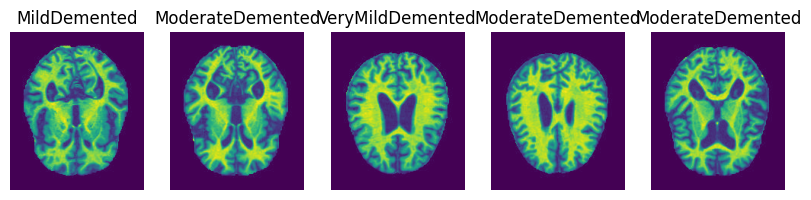

In [7]:
## get classes
classes = [d for d in os.listdir(train_data) if os.path.isdir(os.path.join(train_data,d))]
## selects 5 images at random
images =[]
labels=[]
for i in range (5):
  class_name=random.choice(classes)
  class_path=os.path.join(train_data,class_name)
  image_name=random.choice(os.listdir(class_path))
  images.append(os.path.join(class_path,image_name))
  labels.append(class_name)

#dsiplay of images
plt.figure(figsize=(10,10))
for i, img_path in enumerate(images):
  img=mpimg.imread(img_path)

  plt.subplot(1,5,i+1)
  plt.imshow(img)
  plt.title(labels[i])
  plt.axis('off')

plt.show()

## Test Dataset

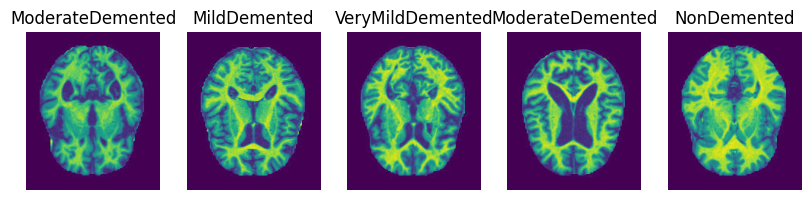

In [8]:
## get classes
classes = [d for d in os.listdir(test_data) if os.path.isdir(os.path.join(test_data,d))]
## selects 5 images at random
images =[]
labels=[]
for i in range (5):
  class_name=random.choice(classes)
  class_path=os.path.join(test_data,class_name)
  image_name=random.choice(os.listdir(class_path))
  images.append(os.path.join(class_path,image_name))
  labels.append(class_name)

#dsiplay of images
plt.figure(figsize=(10,10))
for i, img_path in enumerate(images):
  img=mpimg.imread(img_path)

  plt.subplot(1,5,i+1)
  plt.imshow(img)
  plt.title(labels[i])
  plt.axis('off')

plt.show()

## Valid Dataset

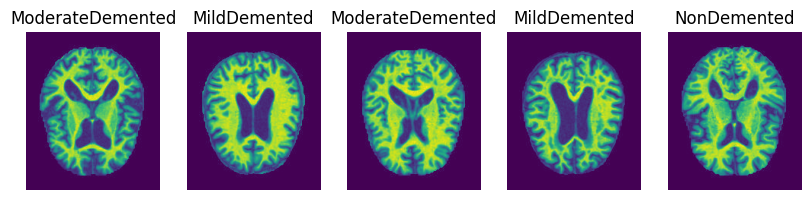

In [9]:
## get classes
classes = [d for d in os.listdir(valid_data) if os.path.isdir(os.path.join(valid_data,d))]
## selects 5 images at random
images =[]
labels=[]
for i in range (5):
  class_name=random.choice(classes)
  class_path=os.path.join(valid_data,class_name)
  image_name=random.choice(os.listdir(class_path))
  images.append(os.path.join(class_path,image_name))
  labels.append(class_name)

#dsiplay of images
plt.figure(figsize=(10,10))
for i, img_path in enumerate(images):
  img=mpimg.imread(img_path)

  plt.subplot(1,5,i+1)
  plt.imshow(img)
  plt.title(labels[i])
  plt.axis('off')

plt.show()

## Exploratory Dataset Analysis (EDA)

Graphs for the Train Dataset

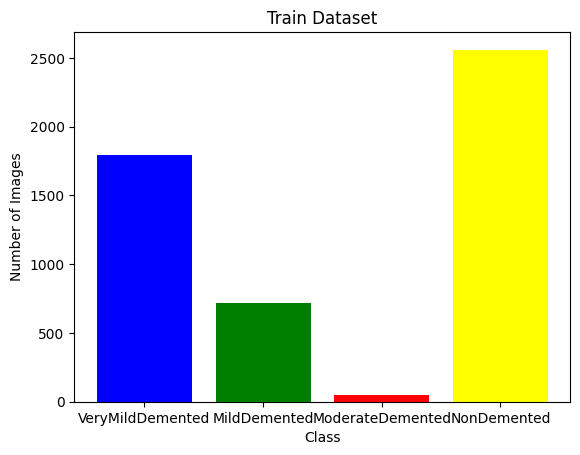

In [10]:
##  count image per class
train_counts= {class_name:len(os.listdir(os.path.join(train_data,class_name))) for class_name in classes}
## plot bar chart
plt.bar(train_counts.keys(), train_counts.values(), color=['blue','green','red','yellow'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Train Dataset')
plt.show()

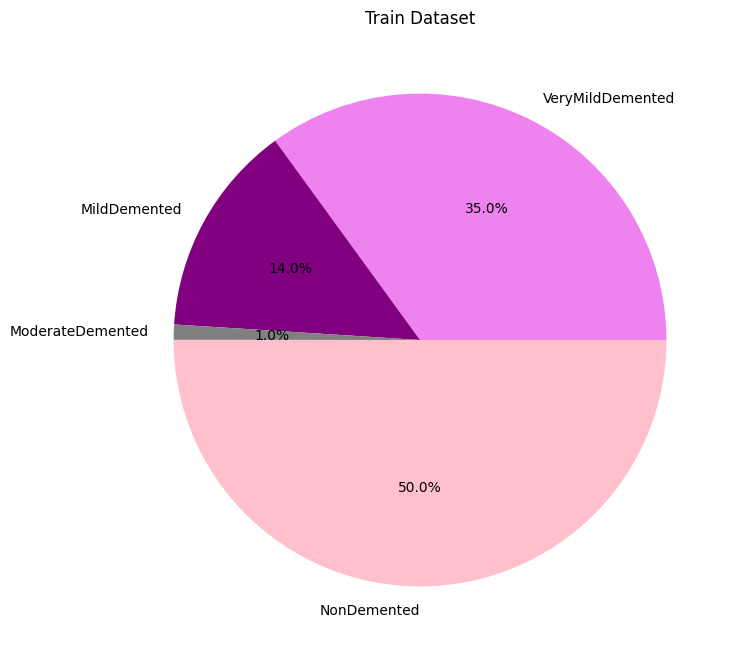

In [11]:
colors=['violet','purple','grey','pink']
# plot pie chart
plt.figure(figsize=(10,8))
plt.pie(train_counts.values(),labels=train_counts.keys(),colors=colors,autopct='%1.1f%%')
plt.title('Train Dataset')
plt.show()

In [12]:
# Function to count images per class
train_counts = {cls: len(os.listdir(os.path.join(train_data, cls))) for cls in os.listdir(train_data) if os.path.isdir(os.path.join(train_data, cls))}

# Merge 'MildDemented', 'VeryMildDemented', 'ModerateDemented' into 'Demented'
merged_counts = {
    'Demented': sum(train_counts[cls] for cls in ['MildDemented', 'VeryMildDemented', 'ModerateDemented']),
    'NonDemented': train_counts['NonDemented']
}

# Print the total counts
print("Total number of Demented images:", merged_counts['Demented'])
print("Total number of NonDemented images:", merged_counts['NonDemented'])

Total number of Demented images: 2559
Total number of NonDemented images: 2560


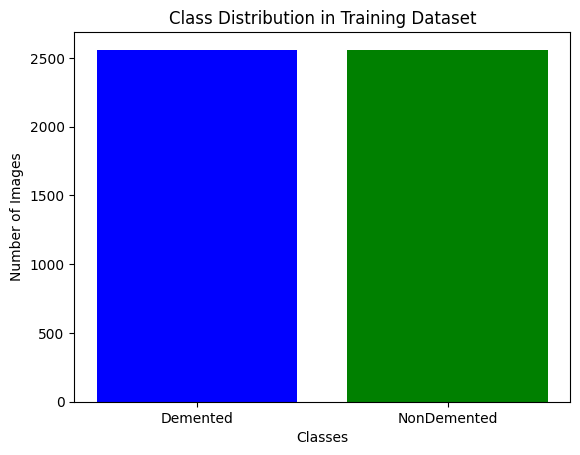

In [13]:
# Function to count images per class
train_counts = {cls: len(os.listdir(os.path.join(train_data, cls))) for cls in os.listdir(train_data) if os.path.isdir(os.path.join(train_data, cls))}

# Merge 'MildDemented', 'VeryMildDemented', 'ModerateDemented' into 'Demented'
merged_counts = {
    'Demented': sum(train_counts[cls] for cls in ['MildDemented', 'VeryMildDemented', 'ModerateDemented']),
    'NonDemented': train_counts['NonDemented']
}

# Plot bar chart
plt.bar(merged_counts.keys(), merged_counts.values(), color=['blue', 'green'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.show()

Test Dataset

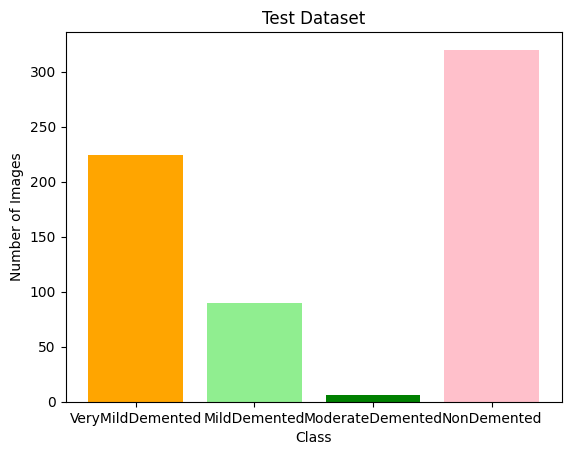

In [14]:
##  count image per class
test_counts= {class_name:len(os.listdir(os.path.join(test_data,class_name))) for class_name in classes}
## plot bar chart
plt.bar(test_counts.keys(), test_counts.values(), color=['orange','lightgreen','green','pink'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Test Dataset')
plt.show()

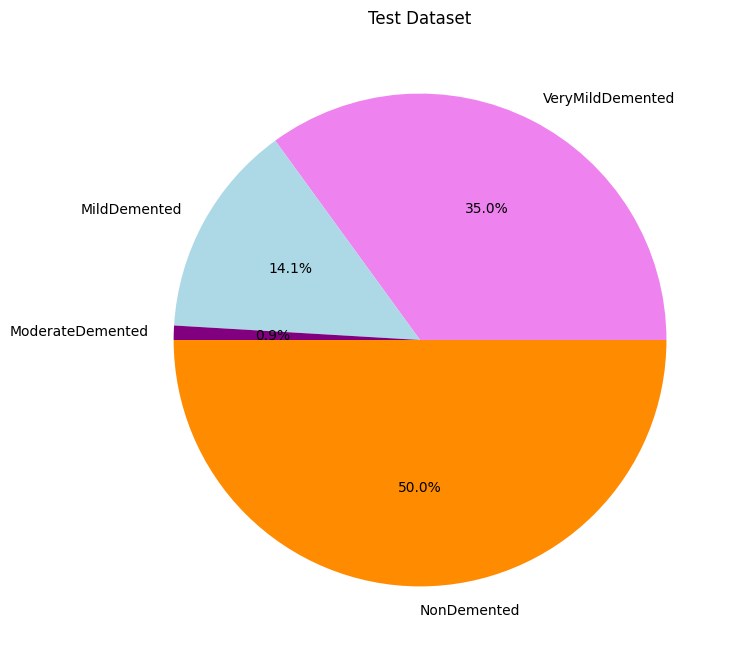

In [15]:
colors=['violet','lightblue','purple','darkorange']
# plot pie chart
plt.figure(figsize=(10,8))
plt.pie(test_counts.values(),labels=test_counts.keys(),colors=colors,autopct='%1.1f%%')
plt.title('Test Dataset')
plt.show()

In [16]:
# Function to count images per class
test_counts = {cls: len(os.listdir(os.path.join(test_data, cls))) for cls in os.listdir(test_data) if os.path.isdir(os.path.join(test_data, cls))}

# Merge 'MildDemented', 'VeryMildDemented', 'ModerateDemented' into 'Demented'
merged_counts = {
    'Demented': sum(test_counts[cls] for cls in ['MildDemented', 'VeryMildDemented', 'ModerateDemented']),
    'NonDemented': test_counts['NonDemented']
}

# Print the total counts
print("Total number of Demented images:", merged_counts['Demented'])
print("Total number of NonDemented images:", merged_counts['NonDemented'])

Total number of Demented images: 320
Total number of NonDemented images: 320


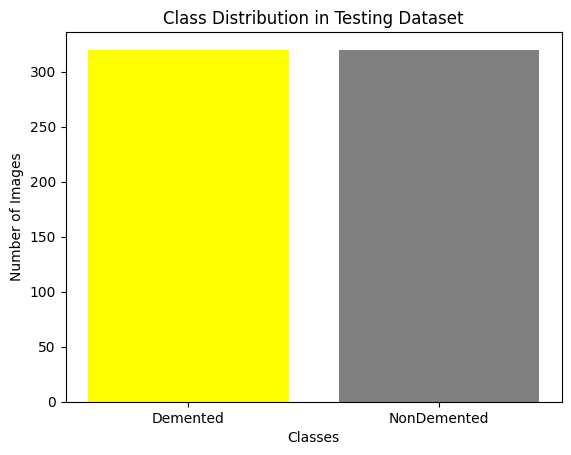

In [17]:
# Function to count images per class
test_counts = {cls: len(os.listdir(os.path.join(test_data, cls))) for cls in os.listdir(test_data) if os.path.isdir(os.path.join(test_data, cls))}

# Merge 'MildDemented', 'VeryMildDemented', 'ModerateDemented' into 'Demented'
merged_counts = {
    'Demented': sum(test_counts[cls] for cls in ['MildDemented', 'VeryMildDemented', 'ModerateDemented']),
    'NonDemented': test_counts['NonDemented']
}

# Plot bar chart
plt.bar(merged_counts.keys(), merged_counts.values(), color=['yellow', 'grey'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Testing Dataset")
plt.show()

Valid Dataset

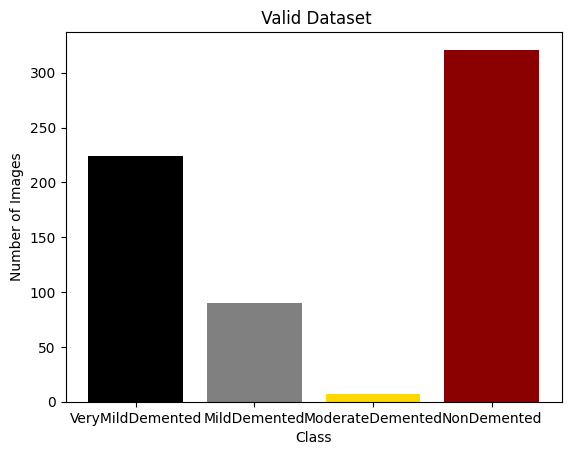

In [18]:
## count image per class
valid_counts= {class_name:len(os.listdir(os.path.join(valid_data,class_name))) for class_name in classes}
## plot bar chart
plt.bar(valid_counts.keys(), valid_counts.values(), color=['black','grey','gold','darkred'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title(' Valid Dataset')
plt.show()

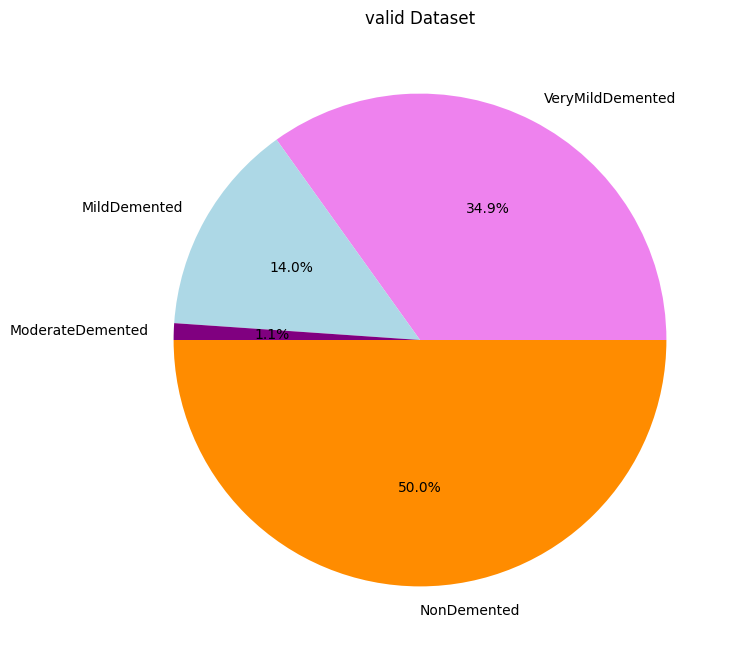

In [19]:
colors=['violet','lightblue','purple','darkorange']
# plot pie chart
plt.figure(figsize=(10,8))
plt.pie(valid_counts.values(),labels=valid_counts.keys(),colors=colors,autopct='%1.1f%%')
plt.title('valid Dataset')
plt.show()

In [20]:
# Function to count images per class
valid_counts = {cls: len(os.listdir(os.path.join(valid_data, cls))) for cls in os.listdir(valid_data) if os.path.isdir(os.path.join(valid_data, cls))}

# Merge 'MildDemented', 'VeryMildDemented', 'ModerateDemented' into 'Demented'
merged_counts = {
    'Demented': sum(valid_counts[cls] for cls in ['MildDemented', 'VeryMildDemented', 'ModerateDemented']),
    'NonDemented': valid_counts['NonDemented']
}

# Print the total counts
print("Total number of Demented images:", merged_counts['Demented'])
print("Total number of NonDemented images:", merged_counts['NonDemented'])

Total number of Demented images: 321
Total number of NonDemented images: 321


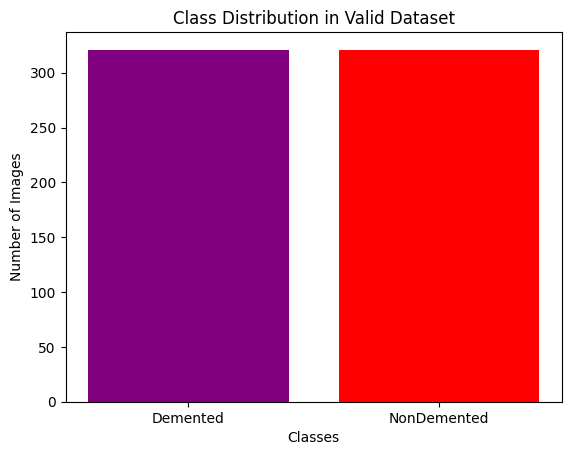

In [21]:
# Function to count images per class
valid_counts = {cls: len(os.listdir(os.path.join(valid_data, cls))) for cls in os.listdir(valid_data) if os.path.isdir(os.path.join(valid_data, cls))}

# Merge 'MildDemented', 'VeryMildDemented', 'ModerateDemented' into 'Demented'
merged_counts = {
    'Demented': sum(valid_counts[cls] for cls in ['MildDemented', 'VeryMildDemented', 'ModerateDemented']),
    'NonDemented': valid_counts['NonDemented']
}

# Plot bar chart
plt.bar(merged_counts.keys(), merged_counts.values(), color=['purple', 'red'])
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Valid Dataset")
plt.show()

## Models

In [22]:
IMG_SIZE=(150,150)
BATCH_SIZE=32

I applied preprocessing to the dataset to ensure that the image size and batch size were uniform across all three splits (train, test, and validation), in order to reduce complexity before applying the model.

In [23]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_data,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_data,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

valid_ds = keras.preprocessing.image_dataset_from_directory(
    valid_data,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)
# Class names
class_names = train_ds.class_names
print(f"Classes: {class_names}")

Found 5119 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


## CNN model

In [24]:
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),  # Normalize
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Reduce overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
##Training cnn model
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    batch_size=BATCH_SIZE
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1796s 11s/step - accuracy: 0.4795 - loss: 1.1512 - val_accuracy: 0.5530 - val_loss: 0.9223
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 43s 91ms/step - accuracy: 0.5632 - loss: 0.9010 - val_accuracy: 0.5935 - val_loss: 0.8160
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.6187 - loss: 0.8082 - val_accuracy: 0.7103 - val_loss: 0.6944
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.6934 - loss: 0.6751 - val_accuracy: 0.7726 - val_loss: 0.5547
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.7814 - loss: 0.5155 - val_accuracy: 0.8287 - val_loss: 0.4307
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.8344 - loss: 0.3967 - val_accuracy: 0.8894 - val_loss: 0.3286
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.8840 - loss: 0.2865 - val_accuracy: 0.9081 - val_loss: 0.2620
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - accuracy: 0.9141 - loss: 0.2161

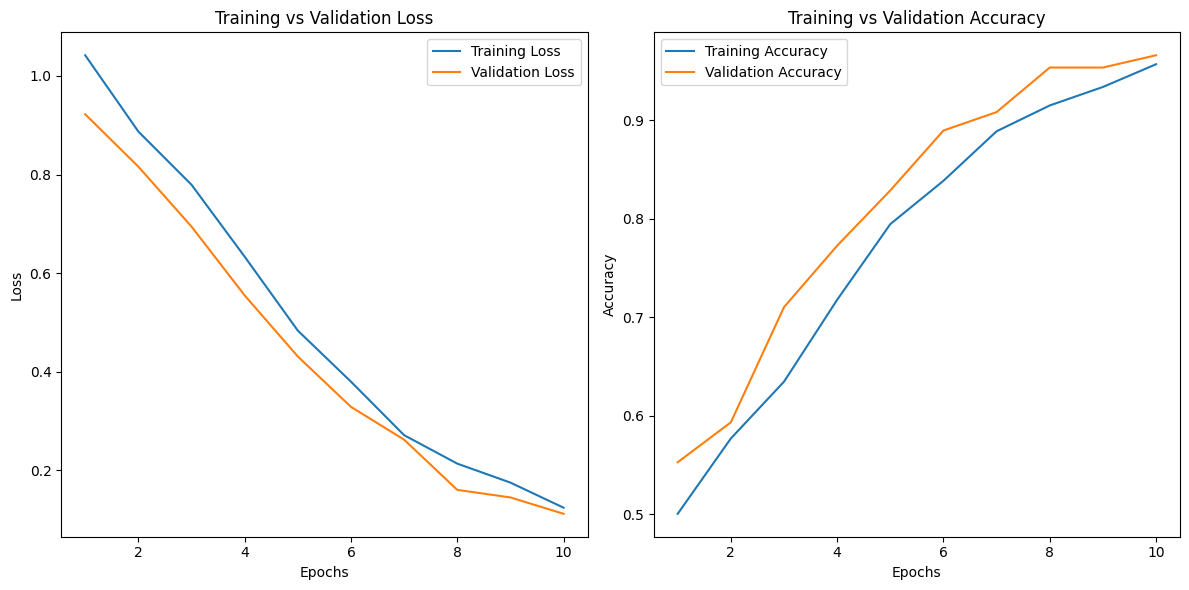

In [26]:
# Extract the training and validation accuracy and loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Create ImageDataGenerator for preprocessing the images
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Evaluate the model on the validation and test datasets
valid_loss, valid_accuracy = model.evaluate(valid_ds)
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy based on the test and validation datasets
print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.9671 - loss: 0.0977
20/20 ━━━━━━━━━━━━━━━━━━━━ 235s 12s/step - accuracy: 0.9689 - loss: 0.0893
Validation Accuracy: 96.57%
Test Accuracy: 95.16%


Found 640 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.96      0.91      0.94        90
VeryMildDemented       1.00      0.83      0.91         6
 

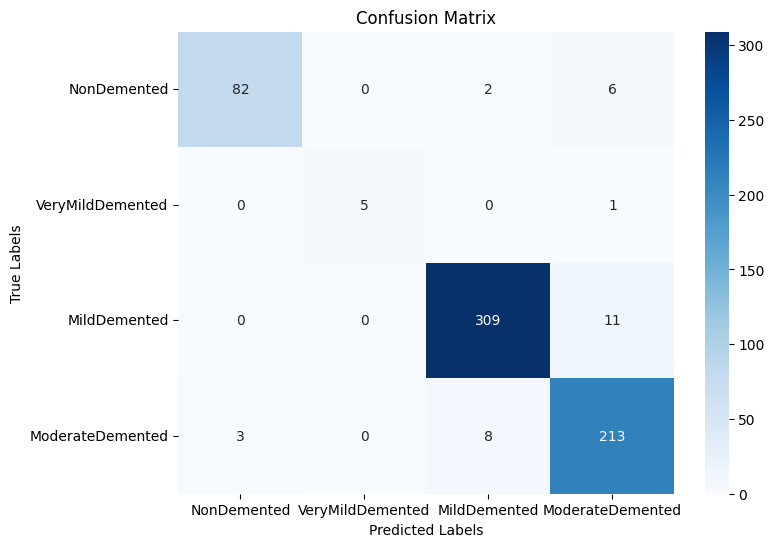

In [28]:

# Class names based on your dataset (as you provided)
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Reset test_data generator to ensure we start from the beginning
test_data = image_dataset_from_directory(test_data, batch_size=32, image_size=(150, 150),
                                         label_mode='categorical', shuffle=False, seed=42)

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for image_batch, label_batch in test_data:
    # Predict class labels for the image batch
    predictions = model.predict(image_batch)

    # Get the predicted class label (highest probability)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get the true class label (index of the class)
    true_classes = np.argmax(label_batch, axis=1)

    # Store the true and predicted labels
    true_labels.extend(true_classes)
    predicted_labels.extend(predicted_classes)

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Efficient Net B0

In [29]:


# Load EfficientNetB0 as base model with pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = True  # Fine-tune the base model

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(4, activation='softmax')  # Output layer for 4-class classification
])

# Compile the model with a lower learning rate for fine-tuning
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=1e-7)

# Display model summary
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,894,311 (22.49 MB)

 Trainable params: 5,849,216 (22.31 MB)

 Non-trainable params: 45,095 (176.16 KB)

In [30]:


# Define callbacks
checkpoint_cb = ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Re-compile the model (in case any changes were made to it)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       metrics.AUC()])  # Add metrics like AUC for evaluation

In [31]:
# Train the model
history = model.fit(
    train_ds,

    validation_data=valid_ds,
    epochs=10,
    batch_size=32,
    callbacks=[lr_reduction]
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 145s 418ms/step - accuracy: 0.4149 - auc: 0.6483 - loss: 1.9570 - val_accuracy: 0.5218 - val_auc: 0.8098 - val_loss: 1.1319 - learning_rate: 0.0010
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.6119 - auc: 0.8535 - loss: 0.9568 - val_accuracy: 0.7072 - val_auc: 0.9250 - val_loss: 0.6680 - learning_rate: 0.0010
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.7813 - auc: 0.9470 - loss: 0.5507 - val_accuracy: 0.6090 - val_auc: 0.8782 - val_loss: 1.1300 - learning_rate: 0.0010
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.8861 - auc: 0.9801 - loss: 0.3267 - val_accuracy: 0.8660 - val_auc: 0.9777 - val_loss: 0.4005 - learning_rate: 0.0010
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.9128 - auc: 0.9881 - loss: 0.2461 - val_accuracy: 0.7710 - val_auc: 0.9390 - val_loss: 0.7473 - learning_rate: 0.0010
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accurac

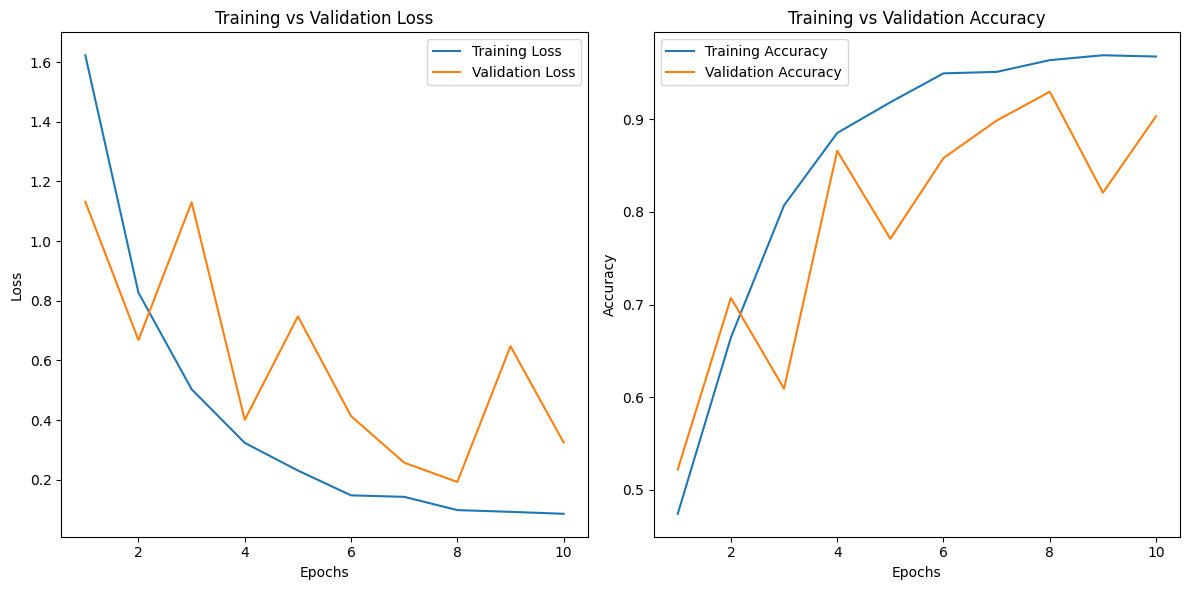

In [32]:
# Extract the training and validation accuracy and loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
# Evaluate the model on the validation and test datasets
valid_loss, valid_accuracy, _ = model.evaluate(valid_ds)  # Assign the third returned value to '_' to ignore it
test_loss, test_accuracy,_ = model.evaluate(test_ds)  # Assign the third returned value to '_' to ignore it

# Print the accuracy based on the test and validation datasets
print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8995 - auc: 0.9830 - loss: 0.3258
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9162 - auc: 0.9927 - loss: 0.2086
Validation Accuracy: 90.34%
Test Accuracy: 91.56%


Found 640 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Classification Report:
                  precision    recall  f1-score   support

     NonDemented       1.00      0.92      0.96        90
VeryMildDemented       1.00      0.67      0.80         6
    

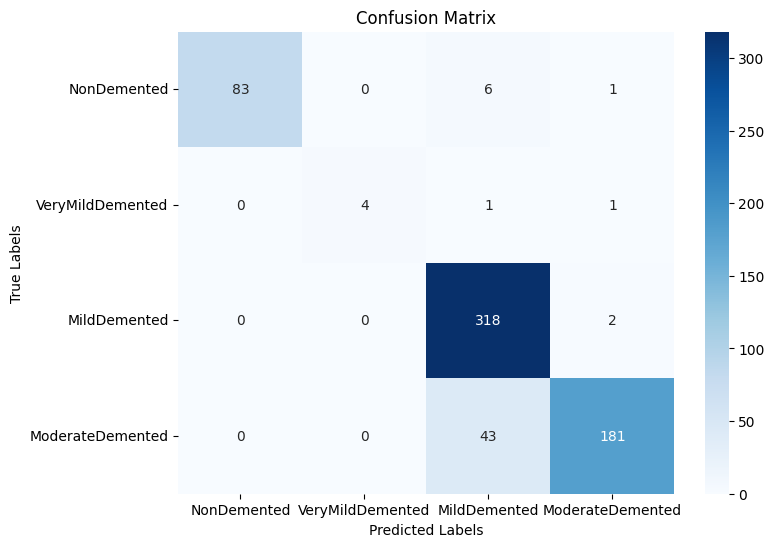

Accuracy from Classification Report: 91.56%


In [34]:


# Class names based on your dataset (as you provided)
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# **Define test_dir here (replace with your actual test directory path)**
test_dir = '/content/drive/MyDrive/Alzheimer_dataset/dir_split/test'

# Reset test_data generator to ensure we start from the beginning
test_data = image_dataset_from_directory(test_dir, batch_size=32, image_size=(150, 150),
                                         label_mode='categorical', shuffle=False, seed=42)

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for image_batch, label_batch in test_data:
    # Predict class labels for the image batch
    predictions = model.predict(image_batch)

    # Get the predicted class label (highest probability)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get the true class label (index of the class)
    true_classes = np.argmax(label_batch, axis=1)

    # Store the true and predicted labels
    true_labels.extend(true_classes)
    predicted_labels.extend(predicted_classes)

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Optionally, print accuracy to compare with the previously obtained accuracy
accuracy = np.sum(np.array(true_labels) == np.array(predicted_labels)) / len(true_labels)
print(f"Accuracy from Classification Report: {accuracy * 100:.2f}%")

## Hybrid Combination of Interception v3  + ResNet 50

In [35]:

# Define Input Shape
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
inputs = Input(shape=input_shape)

# Load InceptionV3 & ResNet50 (Pretrained)
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

inception.trainable = False
resnet.trainable = False
# Extract Features
inception_output = GlobalAveragePooling2D()(inception(inputs))
resnet_output = GlobalAveragePooling2D()(resnet(inputs))

# Concatenate Features with Batch Normalization
merged_features = Concatenate()([inception_output, resnet_output])
merged_features = BatchNormalization()(merged_features)

# Fully Connected Layers
x = Dense(512, activation='relu')(merged_features)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

# Define Model
model = Model(inputs=inputs, outputs=outputs)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 3, 3,      │ 21,802,784 │ input_layer_3[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 5, 5,      │ 23,587,712 │ input_layer_3[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ inception_v3[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 4096)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4096)      │     16,384 │ concatenate_2[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 512)       │  2,097,664 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    131,328 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │      1,028 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,636,900 (181.72 MB)

 Trainable params: 2,238,212 (8.54 MB)

 Non-trainable params: 45,398,688 (173.18 MB)

Training the hybrid model

In [36]:
# Callbacks for Learning Rate Adjustment and Early Stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

# Assuming `train_ds` and `valid_ds` are your training and validation datasets:
# Train Model
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 86s 334ms/step - accuracy: 0.4816 - loss: 1.3583 - val_accuracy: 0.6106 - val_loss: 0.8700 - learning_rate: 1.0000e-04
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.6116 - loss: 0.9417 - val_accuracy: 0.6931 - val_loss: 0.7320 - learning_rate: 1.0000e-04
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.6574 - loss: 0.8323 - val_accuracy: 0.7305 - val_loss: 0.6508 - learning_rate: 1.0000e-04
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - accuracy: 0.6731 - loss: 0.7483 - val_accuracy: 0.7445 - val_loss: 0.5893 - learning_rate: 1.0000e-04
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.7176 - loss: 0.6821 - val_accuracy: 0.7788 - val_loss: 0.5416 - learning_rate: 1.0000e-04
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.7529 - loss: 0.5999 - val_accuracy: 0.8084 - val_loss: 0.5001 - learning_rate: 1.0000e-04
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 11

# Model evaluation

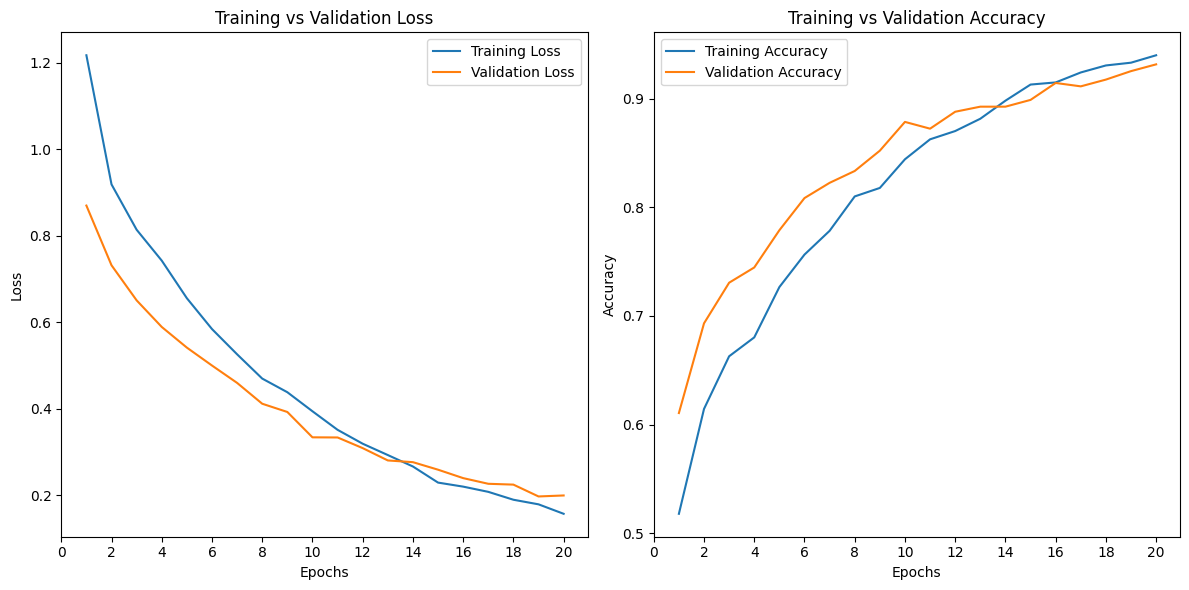

In [37]:
# Extract the training and validation accuracy and loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,21,2))
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,2))
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
# Evaluate the model on the validation and test datasets
valid_loss, valid_accuracy = model.evaluate(valid_ds)
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the accuracy based on the test and validation datasets
print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9187 - loss: 0.2321
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9188 - loss: 0.2118
Validation Accuracy: 93.15%
Test Accuracy: 91.09%


Found 640 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Classification Report:
                  precision    recall  f1-score   support

     NonDemented       0.86      0.93      0.89        90
VeryMildDemented       1.00      0.67    

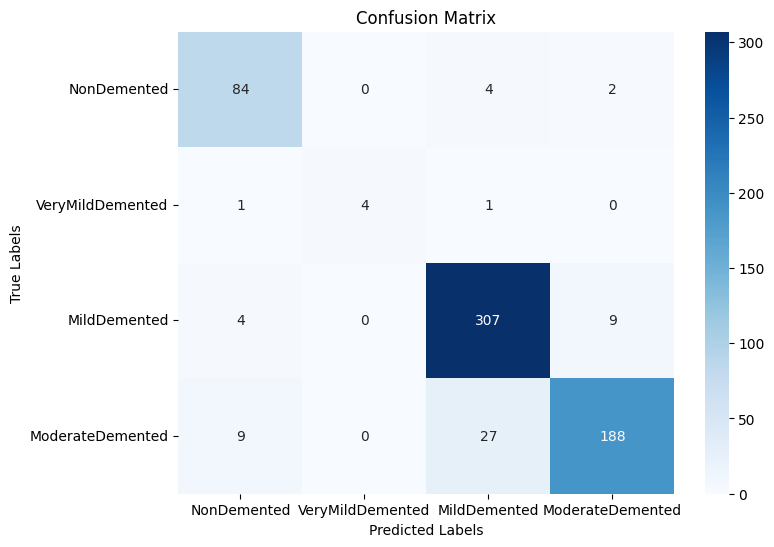

In [39]:


# Class names based on the dataset
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Reset test_data generator to ensure we start from the beginning
test_data = image_dataset_from_directory(test_dir, batch_size=32, image_size=(150, 150),
                                         label_mode='categorical', shuffle=False, seed=42)

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for image_batch, label_batch in test_data:
    # Predict class labels for the image batch
    predictions = model.predict(image_batch)

    # Get the predicted class label (highest probability)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get the true class label (index of the class)
    true_classes = np.argmax(label_batch, axis=1)

    # Store the true and predicted labels
    true_labels.extend(true_classes)
    predicted_labels.extend(predicted_classes)

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


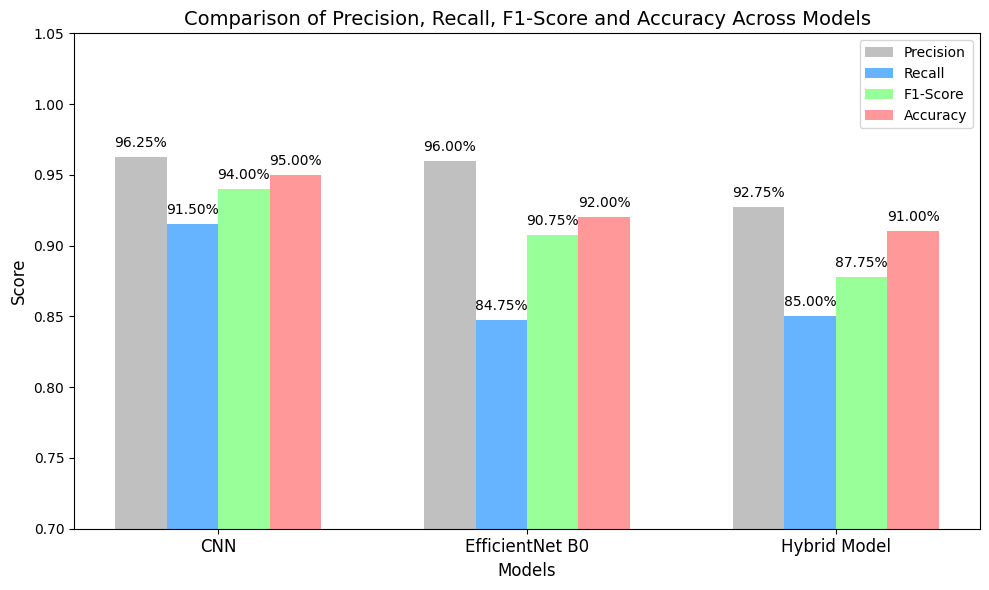

In [66]:
# Define data
models = ["CNN", "EfficientNet B0", "Hybrid Model"]

cnn = {
    "precision": [0.96, 1.00, 0.97, 0.92],
    "recall": [0.91, 0.83, 0.97, 0.95],
    "f1-score": [0.94, 0.91, 0.97, 0.94],
    'accuracy': 0.95
}

efficient_net_bo = {
    "precision": [1.00, 1.00, 0.86, 0.98],
    "recall": [0.92, 0.67, 0.99, 0.81],
    "f1-score": [0.96, 0.86, 0.92, 0.89],
    'accuracy': 0.92
}

hybrid_model = {
    "precision": [0.86, 1.00, 0.91, 0.94],
    "recall": [0.93, 0.67, 0.96, 0.84],
    "f1-score": [0.89, 0.80, 0.93, 0.89],
    'accuracy': 0.91
}

# Compute average scores
precision_scores = [np.mean(cnn["precision"]), np.mean(efficient_net_bo["precision"]), np.mean(hybrid_model["precision"])]
recall_scores = [np.mean(cnn["recall"]), np.mean(efficient_net_bo["recall"]), np.mean(hybrid_model["recall"])]
f1_scores = [np.mean(cnn["f1-score"]), np.mean(efficient_net_bo["f1-score"]), np.mean(hybrid_model["f1-score"])]
accuracy_scores = [cnn['accuracy'], efficient_net_bo['accuracy'], hybrid_model['accuracy']]

# Adjust bar positions
x = np.arange(len(models)) * 1.5
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - 1.5*width, precision_scores, width, label="Precision", color="#C0C0C0")
bars2 = ax.bar(x - 0.5*width, recall_scores, width, label="Recall", color="#66B3FF")
bars3 = ax.bar(x + 0.5*width, f1_scores, width, label="F1-Score", color="#99FF99")
bars4 = ax.bar(x + 1.5*width, accuracy_scores, width, label="Accuracy", color="#FF9999")

# Add values on top of bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.005, f"{height:.2%}", ha='center', va='bottom', fontsize=10)

# Labels and formatting
ax.set_xlabel("Models", fontsize=12)
ax.set_ylabel("Score", fontsize=12)
ax.set_title("Comparison of Precision, Recall, F1-Score and Accuracy Across Models", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.set_ylim(0.7, 1.05)
ax.legend()

plt.tight_layout()
plt.show()


Enter a label (VeryMildDemented, MildDemented, ModerateDemented, NonDemented) or "*" to quit: ModerateDemented
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


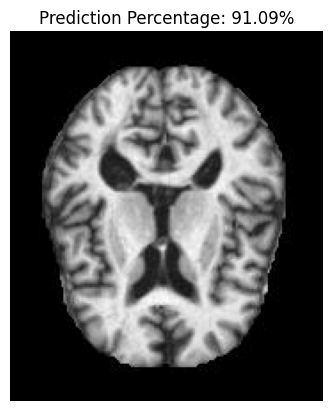

Actual label: ModerateDemented
Predicted label: ModerateDemented
prediction percentage: 91.09%


In [ ]:
# Define base directory for the new dataset
brain_base_dir = '/content/drive/MyDrive/Alzheimer_dataset/dir'

# Folder names for Brain dataset (Class Names)
brain_folders = ['VeryMildDemented', 'MildDemented', 'ModerateDemented', 'NonDemented']

# Combine the Brain folder names into a single labels list
labels = brain_folders

# Define the image size for model input
image_size = (150,150)

# Function to allow user input and display images and accuracy
def user_input_and_accuracy(labels, model):
    correct_predictions = 0
    total_predictions = 0

    while True:
        # Get user input
        user_input = input(f'Enter a label ({", ".join(labels)}) or "*" to quit: ').strip()
        if user_input == '*':
            break
        if user_input not in labels:
            print("Invalid input. Please enter a valid label.")
            continue

        # Select the base directory and label folder based on user input
        label_folder = os.path.join(brain_base_dir, user_input)
        if not os.path.exists(label_folder):
            print("Invalid label folder.")
            continue

        # Select a random image with the user input label
        img_name = random.choice(os.listdir(label_folder))
        img_path = os.path.join(label_folder, img_name)
        img = cv.imread(img_path)
        img_resized = cv.resize(img, image_size)
        img_resized = np.expand_dims(img_resized, axis=0) / 255.0  # Rescale

        # Predict the image using the trained model
        prediction = model.predict(img_resized)
        predicted_label = labels[np.argmax(prediction)]
        prediction_percentage = prediction[0][np.argmax(prediction)] * 100

        # Display the image
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Prediction Percentage: {test_accuracy * 100:.2f}%')
        plt.show()

        # Determine if the user's input is correct
        correct = user_input == predicted_label
        total_predictions += 1
        if correct:
            correct_predictions += 1

        # Calculate and display accuracy
        print(f"Actual label: {user_input}")
        print(f"Predicted label: {predicted_label}")
        print(f'prediction percentage: {test_accuracy * 100:.2f}%')

        input("Press Enter to continue...")

        # Check if accuracy is below 80%
        if accuracy < 80:
            print("Accuracy is below 80%. Please try again.")
            break
user_input_and_accuracy(labels, model)
